# Dowdle's Fuel Efficiency Prediction
**Author:** Brittany Dowdle   
**Date:** 4/13/2025   
**Objective:** This project will demonstrate my ability to apply regression modeling techniques to a real-world dataset. I will:
* Create and save a pipeline based model.   
* Create a RESTful service using the model.   
* Demonstrate receipt of  results from the service.

## Introduction
This project uses the UCI Auto MPG Dataset to predict fuel efficiency based on features such as cylinders, horsepower, and weight. The goal is to predict the MPG for each vehicle. I will create a regression model, split/train the data, evaluate performance using key metrics, and create visualizations to interpret the results.

****

## Imports
In the code cell below are the necessary Python libraries for this notebook. *Pro Tip: All imports should be at the top of the notebook.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

****
## Section 1. Import and Inspect the Data

### 1.1 Load the dataset and display the first 10 rows

In [2]:
# Load the dataset
df = pd.read_csv(r"C:\Projects\ml-regression-dowdle\data\auto-mpg.csv", delimiter=",")

# Display the first 10 rows
df.head(10)

mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   
5  15.0          8         429.0       198.0  4341.0          10.0   
6  14.0          8         454.0       220.0  4354.0           9.0   
7  14.0          8         440.0       215.0  4312.0           8.5   
8  14.0          8         455.0       225.0  4425.0          10.0   
9  15.0          8         390.0       190.0  3850.0           8.5   

   model_year  origin                   car_name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino  
5          70       1           ford galaxie 500  
6          70       1           chevrolet impala  
7          70       1          plymouth fury iii  
8          70       1           pontiac catalina  
9          70       1         amc ambassador dpl

### 1.2 Check for missing values and display summary statistics

In [3]:
# If command is not the last statement in a Python cell, wrap it in the print() function to display.
# Display missing values
print('Missing Values:')
print(df.isnull().sum(), '\n') 

# Display summary statistics
# For numerical columns
print('Summary Statistics (Numerical):')
print(df.describe(include=[np.number]), '\n')
# For categorical columns
print('Summary Statistics (Categorical):')
print(df.describe(include=[object]))

Missing Values:
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64 

Summary Statistics (Numerical):
              mpg   cylinders  displacement  horsepower       weight  \
count  398.000000  398.000000    398.000000  392.000000   398.000000   
mean    23.514573    5.454774    193.425879  104.469388  2970.424623   
std      7.815984    1.701004    104.269838   38.491160   846.841774   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.500000    4.000000    104.250000   75.000000  2223.750000   
50%     23.000000    4.000000    148.500000   93.500000  2803.500000   
75%     29.000000    8.000000    262.000000  126.000000  3608.000000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       acceleration  model_year      origin  
count    398.000000  398.000000  398.000000  
mean      15.568090   76.010050   

### Reflection 1: What do you notice about the dataset? Are there any data issues?
The only column with missing values is horsepower with 6 missing values. The car_name field has a high number of unique values, this means it won't be useful for grouping or modeling without some preprocessing. And features like displacement and weight have very different ranges, which could impact model training if not scaled appropriately. Most of the vehicles seem to be from region 1 based on the origin column median and mode.

****

## Section 2. Data Exploration and Preparation
### 2.1 Explore data patterns and distributions
- Create histograms, boxplots, and count plots for categorical variables (as applicable).

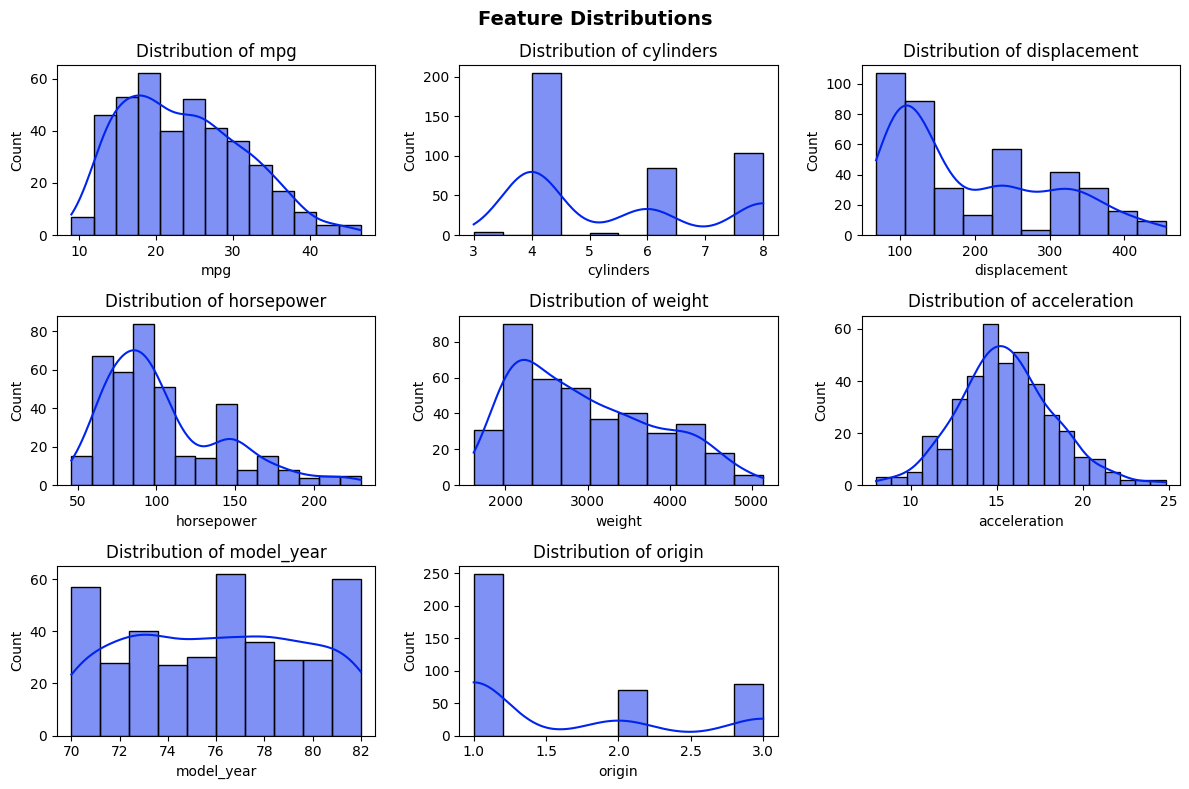

In [4]:
# Select only numerical columns
numeric_cols = df.select_dtypes(include='number').columns

# Create histograms with distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  # Adjust layout for features
    sns.histplot(df[col], kde=True, color=sns.color_palette("winter")[0])
    # Plot titles
    plt.title(f"Distribution of {col}")
# Figure title
plt.suptitle("Feature Distributions", fontsize=14, fontweight='bold')
# Show the plot
plt.tight_layout()
plt.show()

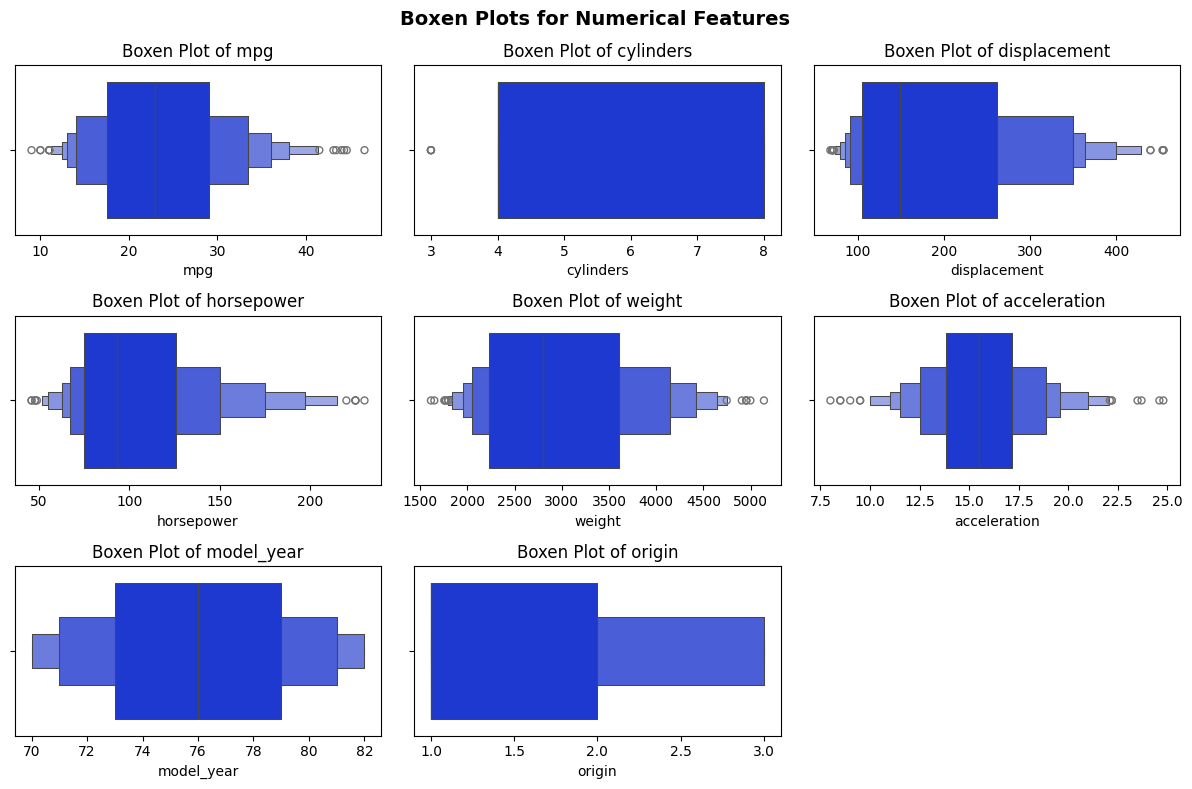

In [5]:
# Create the figure
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()  # Flatten for easy iteration

# Create a boxenplot for each numeric column
for i, col in enumerate(numeric_cols):
    sns.boxenplot(data=df, x=col, ax=axes[i], color=sns.color_palette("winter")[0])
    # Plot titles
    axes[i].set_title(f'Boxen Plot of {col}')

# Hide any unused subplots if fewer than 9 columns
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
# Figure title
plt.suptitle("Boxen Plots for Numerical Features", fontsize=14, fontweight='bold')
# Show the plot
plt.tight_layout()
plt.show()

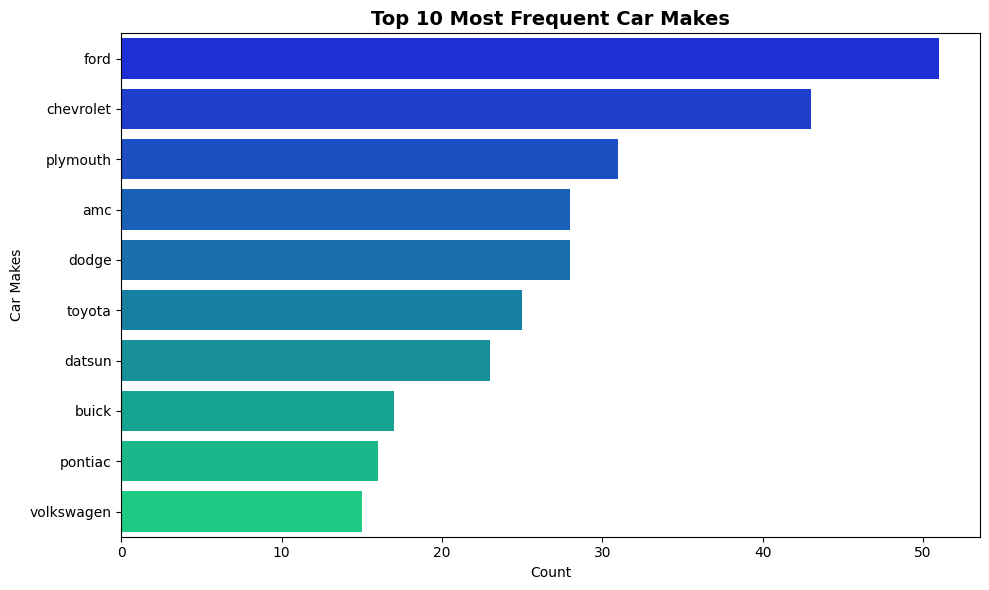

In [6]:
# Select only categorical column
# Extract make (the first word of the car_name)
df['make'] = df['car_name'].str.split().str[0]

# Count top 10 car makes
top_makes = df['make'].value_counts().nlargest(10).reset_index()
top_makes.columns = ['make', 'count']

# Create barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_makes,
    x='count',
    y='make',
    hue='make',
    palette='winter',
    legend=False
)
# Figure title and labels
plt.title('Top 10 Most Frequent Car Makes', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Car Makes')
# Show the plot
plt.tight_layout()
plt.show()

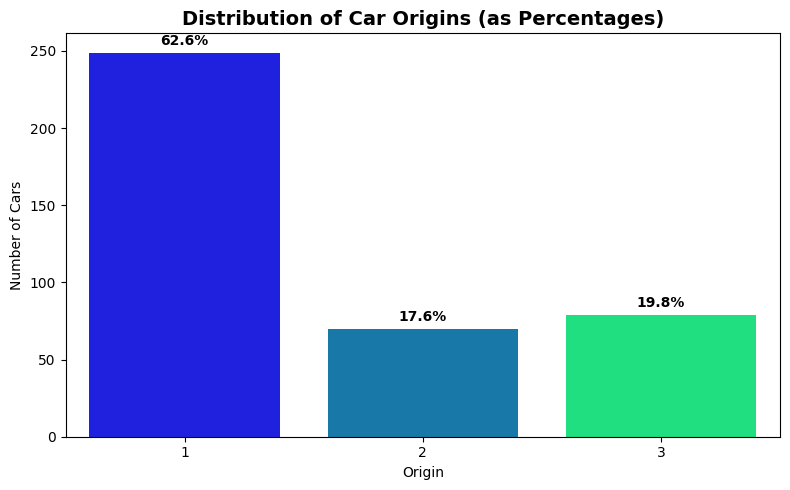

In [7]:
# Total number of rows (for percentage calculation)
total = len(df)

# Count values and sort
origin_counts = df['origin'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='origin', hue='origin', palette='winter', legend=False)

# Add percentage labels
for i, count in enumerate(origin_counts):
    percent = (count / total) * 100
    ax.text(i, count + 3, f'{percent:.1f}%', ha='center', va='bottom', fontweight='bold')

# Titles and labels
plt.title('Distribution of Car Origins (as Percentages)', fontsize=14, fontweight='bold')
plt.xlabel('Origin')
plt.ylabel('Number of Cars')
plt.tight_layout()
plt.show()

- Identify patterns, outliers, and anomalies in feature distributions.

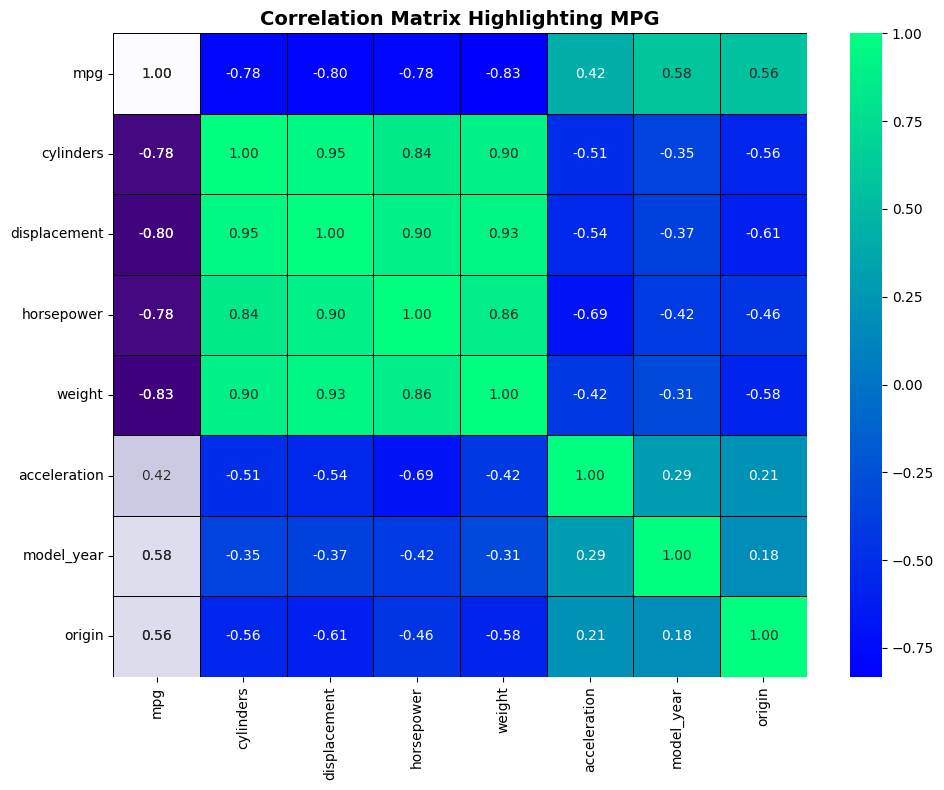

In [8]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])
# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='winter', cbar=True, 
            linewidths=0.5, linecolor='black', annot_kws={"size": 10})

# Highlight the 'mpg' column by making it a different color
highlight = np.zeros_like(corr_matrix, dtype=bool)
highlight[:, corr_matrix.columns.get_loc('mpg')] = True

# Overlay the highlights for 'mpg' column
sns.heatmap(corr_matrix, mask=~highlight, annot=True, fmt=".2f", cmap='Purples_r', 
            cbar=False, linewidths=0.5, linecolor='black')

# Titles and labels
plt.title('Correlation Matrix Highlighting MPG', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

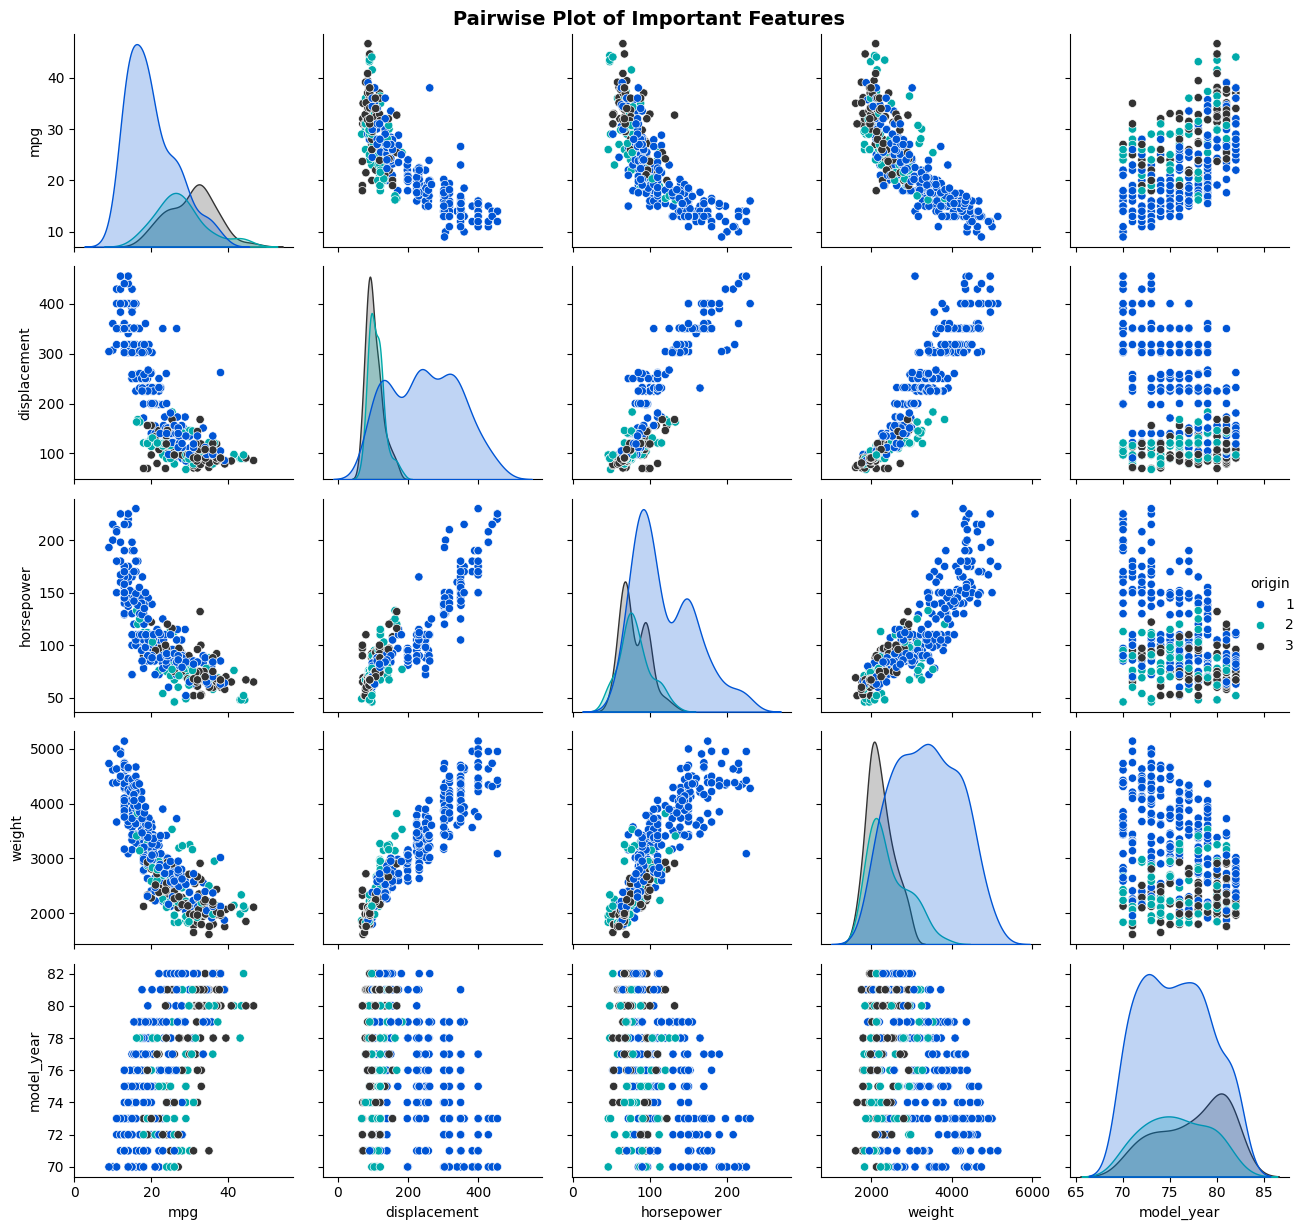

In [9]:
# Select features with high correlation to mpg
pairwise_cols = ['mpg', 'displacement', 'horsepower', 'weight', 'model_year', 'origin']
pairwise_df = df[pairwise_cols].dropna() # Drop rows with missing values

# Create a pairwise plot for features (no categorical columns)
sns.pairplot(pairwise_df, hue="origin", palette="winter_d")  # Hue adds color coding for the 'origin' column
# Figure title
plt.suptitle("Pairwise Plot of Important Features", fontsize=14, fontweight='bold')
# Show the plot
plt.tight_layout()
plt.show()


In [10]:
# Using IQR to detect outliers for all numeric columns
Q1 = numeric_df.quantile(0.25)  # 25th percentile (Q1)
Q3 = numeric_df.quantile(0.75)  # 75th percentile (Q3)
IQR = Q3 - Q1  # Interquartile Range

# Define outlier condition for each column
outlier_condition = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR)))

# Count the number of outliers for each column
outlier_count = outlier_condition.sum()

# Print results
print("\nOutlier count for each column:")
print(outlier_count)


Outlier count for each column:
mpg              1
cylinders        0
displacement     0
horsepower      10
weight           0
acceleration     7
model_year       0
origin           0
dtype: int64


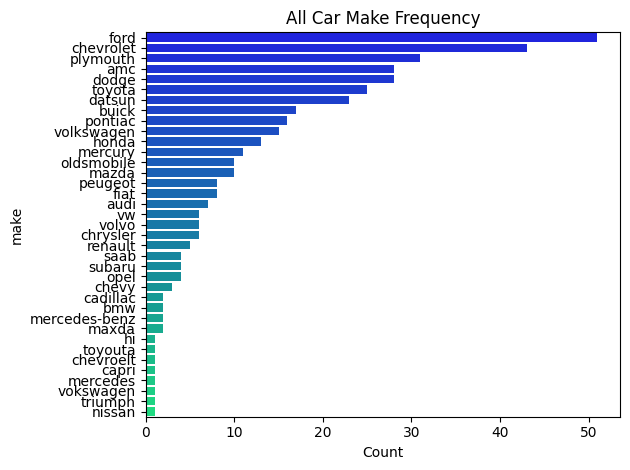

In [11]:
# Create a plot to find typos 
make_counts = df['make'].value_counts()
ordered_make = make_counts.index
# Create a winter gradient color palette
colors = sns.color_palette("winter", n_colors=len(make_counts))
# Create a mapping from brand to color (in same order as brand_counts)
make_color_map = dict(zip(ordered_make, colors))

# Create the plot
sns.countplot(
    data=df,
    y='make',
    order=ordered_make,
    palette=make_color_map,
    hue='make',
    legend=False
)
# Create title and labels
plt.title('All Car Make Frequency')
plt.xlabel('Count')
plt.ylabel('make')
# Show the plot
plt.tight_layout()
plt.show()

- Check for class imbalance in the target variable (as applicable).

In [12]:
# Categorize MPG into two classes: Low and High
# Use the median as the threshold for 2 equal halves
threshold = df['mpg'].median()
df['MPG_Class'] = df['mpg'].apply(lambda x: 'Low' if x < threshold else 'High')

# Check class distribution
class_distribution = df['MPG_Class'].value_counts(normalize=True)

# Show class distribution
print(class_distribution)

# Determine if the dataset is balanced (within 10%)
values = class_distribution.values
difference = abs(values[0] - values[1])

if difference < 0.1:
    print("\nThe dataset is balanced.")
elif 0.1 <= difference < 0.2:
    print("\nThe dataset is slightly imbalanced.")
else:
    print("\nThe dataset is imbalanced.")


MPG_Class
High    0.505025
Low     0.494975
Name: proportion, dtype: float64

The dataset is balanced.


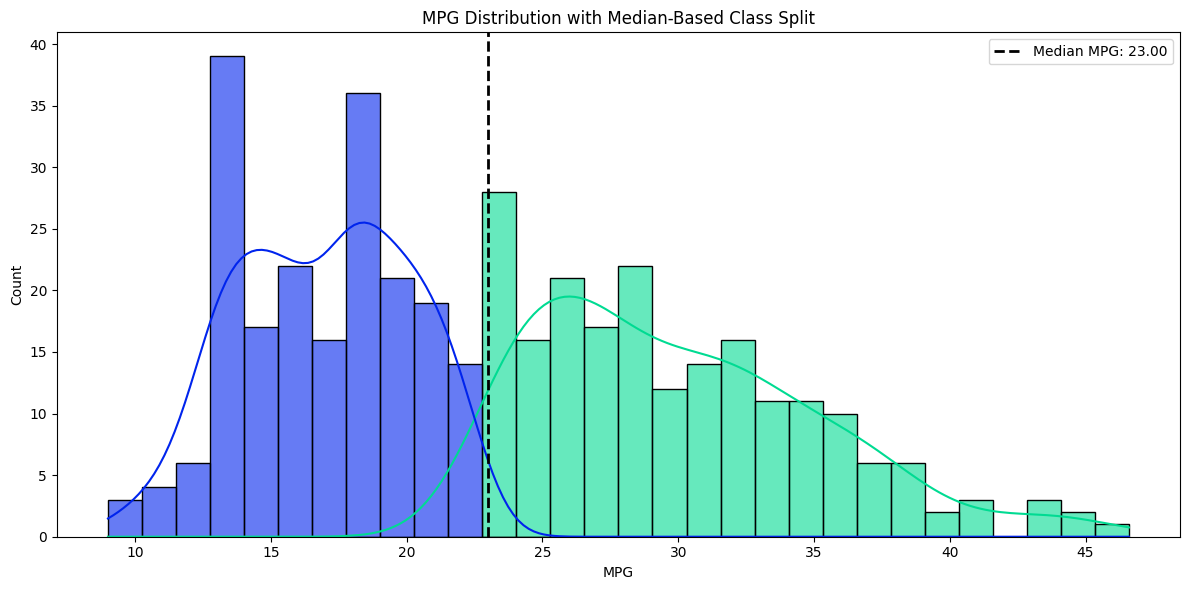

In [13]:
# Create the figure
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='mpg', hue='MPG_Class', bins=30, kde=True, palette={'Low': '#0024ED', 'High': '#00DB92'}, alpha=0.6)
# Create the median line
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Median MPG: {threshold:.2f}')
# Create title and Labels
plt.title('MPG Distribution with Median-Based Class Split')
plt.xlabel('MPG')
plt.ylabel('Count')
# Create legend
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

### 2.2 Handle missing values and clean data
- Impute or drop missing values (as applicable).

In [14]:
# Replace "?" with NaN
df['horsepower'] = df['horsepower'].replace('?', np.nan)
# Convert horsepower to float
df['horsepower'] = df['horsepower'].astype(float)

# Separate into train and test sets (rows with and without horsepower)
train_data_hp = df[df['horsepower'].notna()]
test_data_hp = df[df['horsepower'].isna()]

# Define features to use in prediction
features = ['cylinders', 'displacement', 'weight', 'acceleration', 'model_year']

# Check that there are rows to predict
if not test_data_hp.empty:
    # Train model
    model = LinearRegression()
    model.fit(train_data_hp[features], train_data_hp['horsepower'])

    # Predict missing horsepower
    predicted_hp = model.predict(test_data_hp[features])

    # Fill predicted values back into original DataFrame
    df.loc[test_data_hp.index, 'horsepower'] = predicted_hp
# Confirm there are no missing values
else:
    print("No missing horsepower values to impute.")

- Remove or transform outliers (as applicable): mpg 1, horsepower 10, acceleration 7.

In [15]:
# View rows where mpg is an outlier
mpg_outliers = numeric_df[outlier_condition['mpg']]
print('MPG Outliers:')
print(mpg_outliers, "\n")

# View rows where horsepower is an outlier
horsepower_outliers = numeric_df[outlier_condition['horsepower']]
print('Horsepower Outliers')
print(horsepower_outliers, "\n")

# View rows where acceleration is an outlier
acceleration_outliers = numeric_df[outlier_condition['acceleration']]
print('Acceleration Outliers')
print(acceleration_outliers)

MPG Outliers:
      mpg  cylinders  displacement  horsepower  weight  acceleration  \
322  46.6          4          86.0        65.0  2110.0          17.9   

     model_year  origin  
322          80       3   

Horsepower Outliers
      mpg  cylinders  displacement  horsepower  weight  acceleration  \
6    14.0          8         454.0       220.0  4354.0           9.0   
7    14.0          8         440.0       215.0  4312.0           8.5   
8    14.0          8         455.0       225.0  4425.0          10.0   
13   14.0          8         455.0       225.0  3086.0          10.0   
25   10.0          8         360.0       215.0  4615.0          14.0   
27   11.0          8         318.0       210.0  4382.0          13.5   
67   11.0          8         429.0       208.0  4633.0          11.0   
94   13.0          8         440.0       215.0  4735.0          11.0   
95   12.0          8         455.0       225.0  4951.0          11.0   
116  16.0          8         400.0       230.0 


| Feature | Keep? | Handling | Notes |
|---------|-------|----------|------------|
| mpg | Yes | Leave as-is | 46.6 is realistic and likely a valid data point |
| horsepower | Yes | Log transform | High but valid based on paired features |
| acceleration | Yes | Normalize / Scale | Wide but natural range (muscle - high to economy - low) |

In [16]:
# Log transform (to reduce skew)
df['horsepower_log'] = np.log(df['horsepower'])

# Initialize scaler
scaler = StandardScaler()
# Fit and transform 'acceleration'
df['acceleration_scaled'] = scaler.fit_transform(df[['acceleration']])

- Convert categorical data to numerical format using encoding (as applicable).   
The only column that is categorical is car_name. I don't plan on making this numerical since almost every single row is unique.

### 2.3 Feature selection and engineering   
- Create new features (as applicable).
- Transform or combine existing features to improve model performance (as applicable).
- Scale or normalize data (as applicable).

Earlier a new feature "make" was created by extracting the first word from car_names. I'm going to fix the typos and nicknames found to ensure all unique values are able to be grouped correctly.

In [17]:
# Correct brand name 
df['make'] = df['make'].str.replace('chevroelt|chevrolet|chevy','chevrolet')
df['make'] = df['make'].str.replace('maxda|mazda','mazda')
df['make'] = df['make'].str.replace('mercedes|mercedes-benz|mercedes benz','mercedes')
df['make'] = df['make'].str.replace('toyota|toyouta','toyota')
df['make'] = df['make'].str.replace('vokswagen|volkswagen|vw','volkswagen')
df['make'] = df['make'].str.replace('capri','ford')

# Count unique makes
unique_makes_c = df['make'].nunique()
print(f"Number of unique car makes: {unique_makes_c}", "\n")

# List unique makes
unique_makes_l = df['make'].unique()
# Display them
print("Unique car makes:")
print(sorted(unique_makes_l), "\n")

Number of unique car makes: 36 

Unique car makes:
['amc', 'audi', 'bmw', 'buick', 'cadillac', 'chevroelt', 'chevrolet', 'chevy', 'chrysler', 'datsun', 'dodge', 'fiat', 'ford', 'hi', 'honda', 'maxda', 'mazda', 'mercedes', 'mercedes-benz', 'mercury', 'nissan', 'oldsmobile', 'opel', 'peugeot', 'plymouth', 'pontiac', 'renault', 'saab', 'subaru', 'toyota', 'toyouta', 'triumph', 'vokswagen', 'volkswagen', 'volvo', 'vw'] 



In [18]:
# Scale weight and displacement as well in case they are used in the model
# Using standardscaler from acceleration tranformation for consistency
df[['displacement_scaled', 'weight_scaled']] = scaler.fit_transform(df[['displacement', 'weight']])

Some other features were added to the dataset from creating visuals to determine class balance and handling outliers. All new features are added to the end of the dataset after column car_name.

In [19]:
# Show a few rows with new columns
print("Dataset with new features at the end:")
display(df.head())

Dataset with new features at the end:


mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin                   car_name       make MPG_Class  \
0          70       1  chevrolet chevelle malibu  chevrolet       Low   
1          70       1          buick skylark 320      buick       Low   
2          70       1         plymouth satellite   plymouth       Low   
3          70       1              amc rebel sst        amc       Low   
4          70       1                ford torino       ford       Low   

   horsepower_log  acceleration_scaled  displacement_scaled  weight_scaled  
0        4.867534            -1.295498             1.090604       0.630870  
1        5.105945            -1.477038             1.503514       0.854333  
2        5.010635            -1.658577             1.196232       0.550470  
3        5.010635            -1.295498             1.061796       0.546923  
4        4.941642            -1.840117             1.042591       0.565841

### Reflection 2: What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?

****

## Section 3. Feature Selection and Justification
### 3.1 Choose features and target
- Select two or more input features (numerical for regression, numerical and/or categorical for classification).   
I'm going to try with **weight** and **model_year** year first. If they don't perform well, I will add features and try again.

- Select a target variable (as applicable)   
    Regression: Continuous target variable (e.g., price, temperature).   
    Classification: Categorical target variable (e.g., gender, species).   
    Clustering: No target variable.   
I'm going with regresssion since the target variable is mpg.   

- Justify your selection with reasoning.
Weight had the strongest correlation to mpg from the correlation matrix. And the next highest correlation to mpg that didn't have a strong correlation to weight is model_year. And it showed a slight linear trend to mpg in the pairplot.

### 3.2 Define X and y
- Assign input features to X.
- Assign target variable to y (as applicable).

In [20]:
# Choose features and target
X1 = df[['weight', 'model_year']]
y1 = df['mpg']

# Show the column headings for X and y
print("Features (X) columns:")
print(X1.columns.tolist(), "\n")

print("Target (y) column:")
print(y1.name)

Features (X) columns:
['weight', 'model_year'] 

Target (y) column:
mpg


### Reflection 3: Why did you choose these features? How might they impact predictions or accuracy?

****

## Section 4. Train a Model (Linear Regression)
### 4.1 Split the data into training and test sets using train_test_split (or StratifiedShuffleSplit if class imbalance is an issue).
Section 2.1 determined that the class is balanced. I will use train_test_split.

In [21]:
# Split data into a training set and a test set
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=44)

# Show set sizes
print('Train size:', len(X1_train))
print('Test size:', len(X1_test), "\n")

# Verify sets split properly
# Check if any test samples exist in the training set
overlap = X1_test.merge(X1_train, how="inner", indicator=False)

if not overlap.empty:
    print(f"Data leakage detected! {len(overlap)} rows overlap between train and test sets.", "\n")
else:
    print("No overlapping data between training and test sets.")

Train size: 318
Test size: 80 

Data leakage detected! 3 rows overlap between train and test sets. 



Since I am only using 2 columns in the data, I'm wondering if different cars might coincidentally have the same weight and model_year. I'm going to do a full row overlap check to determine if any more work is necessary.

In [22]:
# Check overlap across all features and target
overlap_full = df.loc[X1_test.index].merge(df.loc[X1_train.index], how="inner")

if not overlap_full.empty:
    print(f"Data leakage detected! {len(overlap_full)} full rows overlap.")
else:
    print("No full row overlap detected.")

No full row overlap detected.


### 4.2 Train model using Scikit-Learn model.fit() method

In [23]:
# Create the model
model1 = LinearRegression()
# Train (fit) the model using training data
model1.fit(X1_train, y1_train)
# Show the coefficients and intercept
print("Model coefficients:", model1.coef_)
print("Model intercept:", model1.intercept_)

Model coefficients: [-0.00665892  0.75171243]
Model intercept: -13.980405047097673


### 4.3 Evalulate performance, for example:
Regression: R^2, MAE, RMSE (RMSE has been recently updated)   
Classification: Accuracy, Precision, Recall, F1-score, Confusion Matrix   
Clustering: Inertia, Silhouette Score

In [24]:
# Make predictions using the trained model
y_pred1 = model1.predict(X1_test)
# Create a DataFrame to show Actual and Predicted values
compare_df1 = pd.DataFrame({
    'Actual': y1_test.values,
    'Predicted': y_pred1    
})

# Show the first few rows of the comparison
print("Compare the values:")
print(compare_df1.head())

Compare the values:
   Actual  Predicted
0    44.6  33.837595
1    29.0  30.846251
2    33.7  32.192097
3    28.0  30.180360
4    33.5  28.384687


In [25]:
# Calculate R² (Coefficient of Determination)
r21 = r2_score(y1_test, y_pred1)
# Display the R² value
print(f"R² Score: {r21:.2f}", "\n")

# Calculate Mean Absolute Error (MAE)
mae1 = mean_absolute_error(y1_test, y_pred1)
# Display the MAE value
print(f"Mean Absolute Error (MAE): {mae1:.2f}", "\n")

# Calculate Root Mean Squared Error (RMSE)
rmse1 = root_mean_squared_error(y1_test, y_pred1)
# Display the RMSE value
print(f"Root Mean Squared Error (RMSE): {rmse1:.2f}", "\n")

# Calculate k-fold cross-validation
scores1 = cross_val_score(model1, X1, y1, cv=5, scoring='neg_root_mean_squared_error')
print("Average RMSE:", (-scores1.mean()))

R² Score: 0.84 

Mean Absolute Error (MAE): 2.52 

Root Mean Squared Error (RMSE): 3.31 

Average RMSE: 3.7678227257419863


The model generalized fairly well, R² is a solid score. MAE shows that on average predictions are off ~2.5 mpg. RSME heavily penalizes large errors but with average RSME being worse, there is some overfitting possible. I'm going to add in one more feature to see if performance increases. 

In [26]:
# Choose features and target
X2 = df[['model_year', 'origin', 'weight']]
y2 = df['mpg']

# Split data into a training set and a test set
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=44)
# Show set sizes
print('Train size:', len(X2_train))
print('Test size:', len(X2_test), "\n")

# Check overlap across all features and target
overlap_full2 = df.loc[X2_test.index].merge(df.loc[X2_train.index], how="inner")

if not overlap_full2.empty:
    print(f"Data leakage detected! {len(overlap_full2)} full rows overlap.")
else:
    print("No full row overlap detected.", "\n")

# Create the model
model2 = LinearRegression()
# Train (fit) the model using training data
model2.fit(X2_train, y2_train)

# Make predictions using the trained model
y_pred2 = model2.predict(X2_test)
# Create a DataFrame to show Actual and Predicted values
compare_df2 = pd.DataFrame({
    'Actual': y2_test.values,
    'Predicted': y_pred2    
})
# Show the first few rows of the comparison
print("Compare the values:")
print(compare_df2.head(), "\n")

# Calculate R² (Coefficient of Determination)
r22 = r2_score(y2_test, y_pred2)
# Display the R² value
print(f"R² Score: {r22:.2f}", "\n")

# Calculate Mean Absolute Error (MAE)
mae2 = mean_absolute_error(y2_test, y_pred2)
# Display the MAE value
print(f"Mean Absolute Error (MAE): {mae2:.2f}", "\n")

# Calculate Root Mean Squared Error (RMSE)
rmse2 = root_mean_squared_error(y2_test, y_pred2)
# Display the RMSE value
print(f"Root Mean Squared Error (RMSE): {rmse2:.2f}", "\n")

# Calculate k-fold cross-validation
scores2 = cross_val_score(model2, X2, y2, cv=5, scoring='neg_root_mean_squared_error')
print("Average RMSE:", (-scores2.mean()))

Train size: 318
Test size: 80 

No full row overlap detected. 

Compare the values:
   Actual  Predicted
0    44.6  34.796848
1    29.0  29.798672
2    33.7  33.407916
3    28.0  29.204271
4    33.5  27.361680 

R² Score: 0.84 

Mean Absolute Error (MAE): 2.49 

Root Mean Squared Error (RMSE): 3.27 

Average RMSE: 3.704594476596543


### Reflection 4: How well did the model perform? Any surprises in the results?

****

## Section 5. Improve the Model or Try Alternates (Implement Pipelines)
### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression.

In [27]:
# Create pipeline1
pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Train (fit) the pipeline using training data
pipeline1.fit(X2_train, y2_train)

# Make predictions using the trained model
y_pred_p1 = pipeline1.predict(X2_test)
# Create a DataFrame to show Actual and Predicted values
compare_df_p1 = pd.DataFrame({
    'Actual': y2_test.values,
    'Predicted': y_pred_p1    
})
# Show the first few rows of the comparison
print("Compare the values:")
print(compare_df_p1.head(), "\n")

# Calculate evaluattion metrics
r2p1 = r2_score(y2_test, y_pred_p1)
maep1 = mean_absolute_error(y2_test, y_pred_p1)
rmsep1 = root_mean_squared_error(y2_test, y_pred_p1)
scoresp1 = cross_val_score(pipeline1, X2, y2, cv=5, scoring='neg_root_mean_squared_error')

# Show evaluation metrics
print(f"R² Score: {r2p1:.2f}", "\n")
print(f"Mean Absolute Error (MAE): {maep1:.2f}", "\n")
print(f"Root Mean Squared Error (RMSE): {rmsep1:.2f}", "\n")
print("Average RMSE:", (-scoresp1.mean()), "\n")

Compare the values:
   Actual  Predicted
0    44.6  34.796848
1    29.0  29.798672
2    33.7  33.407916
3    28.0  29.204271
4    33.5  27.361680 

R² Score: 0.84 

Mean Absolute Error (MAE): 2.49 

Root Mean Squared Error (RMSE): 3.27 

Average RMSE: 3.7045944765965353 



### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression.

In [28]:
# Create pipeline2
pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('polynomial', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Train (fit) the pipeline using training data
pipeline2.fit(X2_train, y2_train)

# Make predictions using the trained model
y_pred_p2 = pipeline2.predict(X2_test)
# Create a DataFrame to show Actual and Predicted values
compare_df_p2 = pd.DataFrame({
    'Actual': y2_test.values,
    'Predicted': y_pred_p2    
})
# Show the first few rows of the comparison
print("Compare the values:")
print(compare_df_p2.head(), "\n")

# Calculate evaluattion metrics
r2p2 = r2_score(y2_test, y_pred_p2)
maep2 = mean_absolute_error(y2_test, y_pred_p2)
rmsep2 = root_mean_squared_error(y2_test, y_pred_p2)
scoresp2 = cross_val_score(pipeline2, X2, y2, cv=5, scoring='neg_root_mean_squared_error')

# Show evaluation metrics
print(f"R² Score: {r2p2:.2f}", "\n")
print(f"Mean Absolute Error (MAE): {maep2:.2f}", "\n")
print(f"Root Mean Squared Error (RMSE): {rmsep2:.2f}", "\n")
print("Average RMSE:", (-scoresp2.mean()), "\n")

Compare the values:
   Actual  Predicted
0    44.6  36.736155
1    29.0  30.152092
2    33.7  34.509520
3    28.0  29.018027
4    33.5  27.104675 

R² Score: 0.90 

Mean Absolute Error (MAE): 1.97 

Root Mean Squared Error (RMSE): 2.66 

Average RMSE: 3.128651053747279 



### 5.3 Compare performance of all models across the same performance metrics

In [29]:
# Define a helper function to compare and evaluate all models
def evaluate_models(models, X_test, y_test, X, y, model_names=None, cv=5):

    results = []
    
    for i, model in enumerate(models):
        name = model_names[i] if model_names else f"Model {i+1}"
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        
        # Cross-validated average RMSE
        scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv)
        avg_rmse = -scores.mean()
        
        results.append({
            "Model": name,
            "R² Score": round(r2, 3),
            "MAE": round(mae, 3),
            "RMSE": round(rmse, 3),
            "Avg RMSE (CV)": round(avg_rmse, 3)
        })
    
    return pd.DataFrame(results)


In [30]:
models = [model2, pipeline1, pipeline2]
model_names = ["LR Only", "Pipeline 1", "Pipeline 2"]

comparison_df = evaluate_models(
    models=models,
    X_test=X2_test,
    y_test=y2_test,
    X=X2,
    y=y2,
    model_names=model_names
)

print(comparison_df)


        Model  R² Score    MAE   RMSE  Avg RMSE (CV)
0     LR Only     0.843  2.494  3.270          3.705
1  Pipeline 1     0.843  2.494  3.270          3.705
2  Pipeline 2     0.896  1.973  2.656          3.129


### Reflection 5: Which models performed better? How does scaling impact results?

****

## Section 6. Final Thoughts & Insights
### 6.1 Summarize findings

### 6.2 Discuss challenges faced

### 6.3 If you had more time, what would you try next?

### Reflection 6: What did you learn from this project?